# Clustering: t-SNE

> **t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction algorithm designed to preserve local neighborhood relationships. It transforms distances between points into similarity probabilities, both in the original space and the projected space, and seeks to minimize the KL divergence between the two.**


The dataset:  

| Point | Coordonnées |
| ----- | ----------- |
| A     | (1, 1)      |
| B     | (2, 1)      |
| C     | (4, 3)      |
| D     | (5, 4)      |
| E     | (3, 4)      |

- **Step-0: Matrix of euclidean distances**  

|   | A   | B   | C   | D   | E   |
| - | --- | --- | --- | --- | --- |
| A | 0.0 | 1.0 | 3.6 | 5.0 | 3.6 |
| B | 1.0 | 0.0 | 2.8 | 4.2 | 3.2 |
| C | 3.6 | 2.8 | 0.0 | 1.4 | 1.4 |
| D | 5.0 | 4.2 | 1.4 | 0.0 | 2.0 |
| E | 3.6 | 3.2 | 1.4 | 2.0 | 0.0 |

- **Step-1: Compute the similarities in the space of origin**

**1.1 Compute the conditional probabilities $p_{j|i}$.**  

In t-SNE, each point $x_i$ defines a conditional probability distribution over all other points $x_j$, which reflects how likely $x_j$ is to be a neighbor of $x_i$.  
This is computed using a Gaussian distribution centered at $x_i$:  

$$p_{j|i} = \dfrac{exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i}exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$$  

* $\sigma_i$ is the bandwith of the Gaussian centered at $x_i$.
* It is usually determined automatically via binary search to match a predefinied **perplexity** (which controls the effective number of neighbors, typically 5-50).
* The perplexity corresponds to the entropy $H(p_i)$ of the distribution:  
$$\text{Perplexity}(p_i) = 2^{H(p_i)} \Rightarrow H(p_i) = log_2(\text{Perplexity})$$  
In this example, we assume perplexity = 2, so:  
$$H_(p_i) \approx \log_2(2) = 1$$

For simplification, we assume that $\sigma_i = 1$ for all points (i.e., we skip the binary search and fix the bandwidth).

Example with the conditional probabilities for the point $A$:  

Distance from point $x_i = A$ to others: $[0.0, 1.0, 3.6, 5.0, 3.6]$   

We ignore the distance to itself $(0.0)$, and compute unnormalized similarities $p_{j|A} = exp(-\dfrac{d^2}{2})$:  

B: $exp(-\dfrac{1^2}{2}) = exp(-0.5) \approx 0.6065$

C: $exp(-\dfrac{3.6^2}{2}) = exp(-6.48) \approx 0.0015$

D: $exp(-\dfrac{5.0^2}{2}) = exp(-12.5) \approx 3.726e-6$

E: $exp(-\dfrac{3.6^2}{2}) = exp(-6.48) \approx 0.0015$

Now normalize:  

$\sum_{j \neq A}exp(-\dfrac{||x_A - x_j||^2}{2}) = 0.6065 + 0.0015 + 3.7e-6 + 0.0015 \approx 0.6095$  

$$\Rightarrow p_{B|A} \approx \dfrac{0.6065}{0.6095} \approx 0.995$$


This means that point $A$ considers point $B$ to be a very likely neighbor, while points $C, D$, and $E$ are effectively ignored.  

The conditional probability $p_{j|i}$ captures how similar or close point $j$ is to point $i$.

**1.2 Symetrisation.**  

The values of the conditional probabilities are asymmetric meaning $p_{j|i} \neq p_{i|j}$.  
To obtain a joint probability distribution over pairs of points, t-SNE symmetrizes them as follows:  

$$p_{ij} = \dfrac{p_{j|i} + p_{i|j}}{2n}$$  

Here, $n$ is the number of data points. This results in a symmetric matrix of pairwise similarities in the original high we obtain a symetric matrix of similarity in the original high-dimensional space.  

- **Step-2: Compute the similarities in the 'espace bas' (2D)**  

We now map the data points into a low-dimensional space—typically 2D—by assigning each point a randomly initialized position $y_i. 
Then, we compute a new similarity measure $q_{ij}$ between $y_i$ and $y_j$ using a Student's t-Distribution with one degree of freedom (also known as a Cauchy distribution):  

$$q_{ij} = \dfrac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_k - y_l||^2)^{-1}}$$  

This heavy-tailed distribution helps to strongly repel dissimilar points, improving the separation in the 2D projection compared to a Gaussian.  


- **Step-3: Minimization de la divergence KL**  

The goal of t-SNE is to make the low-dimensional distribution $Q = {q_{ij}}$ resemble the high-dimensional distribution $P={p_{ij}}$. 
To achieve this, we miinimize the Kullback-Leibler (KL) divergence between the two distributions:  

$$KL(P||Q) = \sum_{i \neq j}p{ij}log \dfrac{p_{ij}}{q_{ij}}$$  

This loss function is minimized using gradient descent. The gradient of the cost function with respect to a point $y_i$ is given by:  

$$\dfrac{dC}{dy_i} = 4 \sum_j(p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$$


This update moves the low-dimensional points $y_i$ in a way that:  

* Pulls similar points closer (when $p{ij} > q{ij}$),
* Pushes dissimilar points apart (when $p{ij} < q{ij}$).  

The positions of the low-dimensional points $y_i$ are updated iteratively until convergence.  


📌 Conclusion: Why t-SNE Preserves Local Structure. 

| Property                   | Explanation                                                                |
| -------------------------- | -------------------------------------------------------------------------- |
| Gaussian distribution      | Models neighborhoods in the original high-dimensional space                |
| Student’s t-distribution   | Strongly separates dissimilar points in the low-dimensional space          |
| KL divergence as cost      | Ensures an accurate reconstruction of **local relationships**              |
| Suitable for visualization | t-SNE produces intuitive and readable visualizations, even for non-experts |

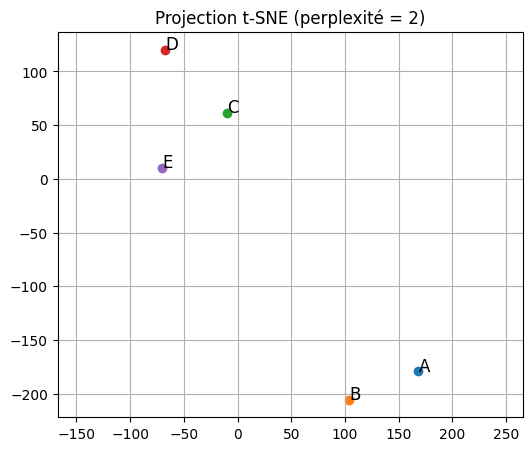

In [1]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

points = {
    'A': (1, 1),
    'B': (2, 1),
    'C': (4, 3),
    'D': (5, 4),
    'E': (3, 4)
}
labels = list(points.keys())
X = np.array([points[k] for k in labels])

tsne = TSNE(n_components=2, perplexity=2, learning_rate='auto', init='random', random_state=0)
X_emb = tsne.fit_transform(X)

plt.figure(figsize=(6, 5))
for i, label in enumerate(labels):
    x, y = X_emb[i]
    plt.scatter(x, y)
    plt.text(x + 0.2, y + 0.2, label, fontsize=12)
plt.title("Projection t-SNE (perplexité = 2)")
plt.axis('equal')
plt.grid(True)
plt.show()
